# TP2 - Quadratic Assignment Problem

### Author: Petter Stahle (*petter.stahle@etu.unige.ch*)

In [96]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from time import process_time

np.set_printoptions(precision=3)

plt.style.use(['science', 'notebook', 'grid'])

## Data

Here we define a an example instance of the data for the problem.

In [2]:
n = 5

# Distances
D = np.array([[0,1,1,2,3],
              [1,0,2,1,2],
              [1,2,0,1,2],
              [2,1,1,0,1],
              [3,2,2,1,0]])
# Flows
W = np.array([[0,5,2,4,1],
              [5,0,3,0,2],
              [2,3,0,0,0],
              [4,0,0,0,5],
              [1,2,0,5,0]])       

## Tabu Search Algorithm

### Boilerplate - abstract tabu search class

In [86]:
class TabuList():

    def __init__(self, tenure: int=1, diversification=False, u=None) -> None:
        # Generate the empty tabu list
        self.tenure = tenure

    def add(self, node: tuple, current_iteration: int) -> None:
        # Add movement "x0 -> x1" to tabu list
        pass

    def is_tabu(self, node: tuple, current_iteration: int) -> bool:
        # Return whether a movement "xi -> xj" is tabu or not
        pass

    def remove(self, node: tuple) -> None:
        # Used in combination with the long-term memory, which allows an element to be removed from
        # the tabu list if certain conditions are met.
        pass

    def get_value(self):
        pass

    def diversify(self):
        pass

class TabuSearch():

    goal = None # Goal of the objective function (either min or max)

    def __init__(self, diversification=False, u=None, max_t: int=20000) -> None:
        # Generate random x0
        # Assign empty tabu list
        # self.tabu_list = self.tabu_list_impl()
        # Initialize iteration 0
        self.max_t = max_t
        self.diversification = diversification
        if diversification:
            self.u = u 
        self._current, self._next = None, None
        self.tabu_list = None
        
    def search(self, debug=False) -> tuple:
        best_el = self._current
        best_score = self.objective_function(self._current)
        path = [(best_el, best_score)]
        for t in range(1, self.max_t+1):
            if debug:
                print("Iteration - ", t)
                print("Current: ", self._current)
                print("Best score: ", best_score)
                print("Tabu list: \n", self.tabu_list.get_value())
                print("----------------")
            # Select the best non-tabu neighbor
            neighbors = self._get_neighbors(self._current)
            self._next, score = self._get_next(self._current, neighbors, t)
            # Update best solution so far
            if self._is_better(score, best_score):
                best_el, best_score = self._next, score
            # Update tabu list
            self._update_tabu_list(t)
            # Update current node
            self._current = self._next
            path.append((self._next, score))

        return best_el, best_score, path

    def _update_tabu_list(self, t: int) -> None:
        self.tabu_list.add((self._current, self._next), t)

    def _get_neighbors(self, element) -> list:
        # To implement
        pass

    def _get_next(self, element, neighbors: list, t: int) -> tuple:
        # Select best of non-tabu movements
        allowed_neighbors = []
        for neighbor in neighbors:
            if not self.tabu_list.is_tabu((element, neighbor), t):
                allowed_neighbors.append(neighbor)

        # Add diversification
        if self.diversification:
            allowed_neighbors = self.tabu_list.diversify(element, allowed_neighbors, t)

        next_neighbor, score = self._find_optimal(allowed_neighbors)
        return next_neighbor, score

        
    def objective_function(self, element) -> int:
        # To implement
        pass

    def _is_better(self, score_1, score_2) -> bool:
        # Return whether score 1 is better than score 2
        return score_1<=score_2 if self.goal=='min' else score_1>=score_2

    def _find_optimal(self, elements):
        scores = np.empty(len(elements))
        for i, el in enumerate(elements):
            score = self.objective_function(el)
            scores[i] = score
        # minimize or optimize objective function
        id_best = np.argmin(scores) if self.goal=='min' else np.argmax(scores)
        best_score = scores[id_best]
        best_el = elements[id_best]

        return best_el, best_score
        

# IMPLEMENTATION

class TabuMatrix(TabuList):
    def __init__(self, n: int, tenure: int=1, diversification=True, u=None) -> None:
        super().__init__(tenure=tenure)
        self.n = n
        self.tabu_matrix = np.zeros((n,n), dtype=int)
        self.diversification = diversification
        if diversification:
            self.u = u if u is not None else n**2
            self.placements = self.tabu_matrix.copy() # stores the last placement of a facility in a given position


    def add(self, node, t: int) -> None:
        x0 = node[0]
        x1 = node[1]
        # To see what the 2-swap was, subtract both vectors and see which elements are non equal to 0
        # E.g: x0 ([2,3,1,0]) - x1 ([1,3,2,0]) = [1,0,-1,0]
        # So facility 2 was removed from position 0, and facility 1 from position 2
        # ---> insert t+tenure inside the tabu matrix in positions [0,2] and [2,1]
        removed_positions = np.where((x0-x1)!=0)[0]
        removed_facilities = [ x0[removed_positions[0]], x0[removed_positions[1]] ]

        for pos, fac in zip(removed_positions, removed_facilities):
            self.tabu_matrix[pos][fac] = t + self.tenure

    def is_tabu(self, node, t: int) -> None:
        x0 = node[0]
        x1 = node[1]
        # Check if movement is tabu, by checking if the values in the tabu matrix
        # associated to the positions of facililities removed in the 2-swap
        # are both greater than the current iteration t

        # To see what the 2-swap was, subtract both vectors and see which elements are non equal to 0
        # E.g: x0 ([2,3,1,0]) - x1 ([1,3,2,0]) = [1,0,-1,0]
        # So facility 2 was removed from position 0, and facility 1 from position 2
        # ---> insert t+tenure inside the tabu matrix in positions [0,2] and [2,1]
        removed_positions = np.where((x0-x1)!=0)[0]
        removed_facilities = [ x0[removed_positions[0]], x0[removed_positions[1]] ]

        for pos, fac in zip(removed_positions, removed_facilities):
            if self.tabu_matrix[pos][fac] < t:
                return False
        return True
    
    def diversify(self, current, neighbors: list, t: int) -> list:
        # Filter out neighbors by only selecting those where the corresponding move is allowed.
        # A move is allowed if one of its 2 new added placements has not occured in the last u iterations
        # This is verified by looking in the placements matrix for any (r,i) that has a value smaller than t-u
        
        # Get the placements older than u iterations
        old_placements = np.where(self.placements<(t-self.u))
        old_placements = [o for o in zip(old_placements[0], old_placements[1])] # ex. [(0, 0), (0, 1), (0, 2), (1, 0), (1, 2), (1, 3)...]

        if len(old_placements)>0:
            x0 = current
            allowed_neighbors = []
            for neighbor in neighbors:
                x1 = neighbor
                # Same logic as in add() and is_tabu() to get extract added positions from a move
                added_positions = np.where((x0-x1)!=0)[0]
                added_facilities = [ x1[added_positions[0]], x1[added_positions[1]] ]

                old = False
                for pos, fac in zip(added_positions, added_facilities):
                    if (pos, fac) in old_placements:
                        old = True
                if old:
                    allowed_neighbors.append(neighbor)

            # Manage case when allowed nodes is empty
            # In this case we force a new node to have a random old placement
            if len(allowed_neighbors) == 0:
                new_id = np.random.choice(np.arange(len(old_placements)))
                r, i = old_placements[new_id]
                allowed_neighbors.append(self._swap(x0), r, i)
                
            return allowed_neighbors
        else:
            return neighbors
        
    @staticmethod
    def _swap(x, r, i):
        # add facility i to position r in permutation x, and swap accordingly
        i_ = x[r] # facility to swap with
        r_ = x.index(i) # position to swap with
        new = x.copy()
        # swap
        new[r], new[r_] = i, i_
        return new
        
    def get_value(self):
        return self.tabu_matrix

class QAPTabuSearch(TabuSearch):
    goal = 'min'
    def __init__(self, n: int, D: np.ndarray, W: np.ndarray, tenure: int=1, diversification=False, u=None, max_t: int=20000) -> None:
                # Generate random x0
        super().__init__(max_t=max_t)
        if D.shape != W.shape or D.shape != (n,n):
            raise ValueError(f'Incompatible input shapes for D, W with n={n}, got {D.shape} and {W.shape} respectively.')
        self.n = n
        self.D = D
        self.W = W
        self._current = np.random.permutation(self.n)
        self.tabu_list = TabuMatrix(n, tenure=tenure, diversification=diversification, u=u)

    def _get_neighbors(self, x) -> list:
        neighbors = []
        for i in range(self.n):
            for j in range(i+1, self.n):
                neighbor = x.copy()
                neighbor[i], neighbor[j] = x[j], x[i] # 2-swap
                neighbors.append(neighbor)
        return neighbors

    def objective_function(self, x) -> int:
        # Note: This operation can be optimised if we can somehow
        # find the operation to permute D's indeces.
        cost = 0
        for i in range(self.n):
            for j in range(self.n):
                cost += self.W[i,j]*self.D[x[i],x[j]]
        return cost

## Load data from task definiiton file

In [6]:
def read_data(file):
    with open(file, 'r') as f:
        buffer = f.read()
        # print(buffer)
        n, D, W = buffer.split('\n\n')
        n = int(n)
        D = np.fromstring(D, sep=' ', dtype=int).reshape(n,n)
        W = np.fromstring(W, sep='  ', dtype='float').reshape(n,n)

    return n, D, W
        

# print(read_data('1.dat'))
n, D, W = read_data('1.dat')
print(n)
print(D)
print(W)

12
[[0 1 2 3 1 2 3 4 2 3 4 5]
 [1 0 1 2 2 1 2 3 3 2 3 4]
 [2 1 0 1 3 2 1 2 4 3 2 3]
 [3 2 1 0 4 3 2 1 5 4 3 2]
 [1 2 3 4 0 1 2 3 1 2 3 4]
 [2 1 2 3 1 0 1 2 2 1 2 3]
 [3 2 1 2 2 1 0 1 3 2 1 2]
 [4 3 2 1 3 2 1 0 4 3 2 1]
 [2 3 4 5 1 2 3 4 0 1 2 3]
 [3 2 3 4 2 1 2 3 1 0 1 2]
 [4 3 2 3 3 2 1 2 2 1 0 1]
 [5 4 3 2 4 3 2 1 3 2 1 0]]
[[ 0.  5.  2.  4.  1.  0.  0.  6.  2.  1.  1.  1.]
 [ 5.  0.  3.  0.  2.  2.  2.  0.  4.  5.  0.  0.]
 [ 2.  3.  0.  0.  0.  0.  0.  5.  5.  2.  2.  2.]
 [ 4.  0.  0.  0.  5.  2.  2. 10.  0.  0.  5.  5.]
 [ 1.  2.  0.  5.  0. 10.  0.  0.  0.  5.  1.  1.]
 [ 0.  2.  0.  2. 10.  0.  5.  1.  1.  5.  4.  0.]
 [ 0.  2.  0.  2.  0.  5.  0. 10.  5.  2.  3.  3.]
 [ 6.  0.  5. 10.  0.  1. 10.  0.  0.  0.  5.  0.]
 [ 2.  4.  5.  0.  0.  1.  5.  0.  0.  0. 10. 10.]
 [ 1.  5.  2.  0.  5.  5.  2.  0.  0.  0.  5.  0.]
 [ 1.  0.  2.  5.  1.  4.  3.  5. 10.  5.  0.  2.]
 [ 1.  0.  2.  5.  1.  0.  3.  0. 10.  0.  2.  0.]]


## Compute average scores for different tenures $l = 1, 6, 10$

In [10]:
# no diversification
results_no_diver = [[], [], []]
max_t = 10000
tenures = [1, int(0.5*n), int(0.9*n)]
for i in tqdm(range(10)):
    # print("iteration - ", i)
    for k, l in enumerate(tenures):
        # print("tenure - ", l)
        ts = QAPTabuSearch(n, D, W, diversification=False, tenure=l, max_t=max_t)
        _, score, _ = ts.search()
        results_no_diver[k].append(score)

  0%|          | 0/10 [00:00<?, ?it/s]

Results - no diversification:
Best:  [582.0, 578.0, 578.0]
Mean:  [607.8, 592.0, 592.6]
Std:  [18.054362353736007, 8.854377448471462, 9.079647570252932]


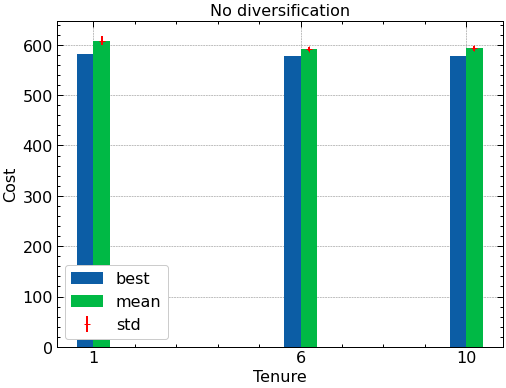

In [11]:
best = [np.min(scores) for scores in results_no_diver]
mean = [np.mean(scores) for scores in results_no_diver]
std = [np.std(scores) for scores in results_no_diver]

print("Results - no diversification:")
print("Best: ", best)
print("Mean: ", mean)
print("Std: ", std)

tenures = np.array(tenures)
plt.bar(tenures-0.2, best, 0.4, label="best")
plt.bar(tenures+0.2, mean, 0.4, label="mean")
plt.errorbar(tenures+0.2, mean, np.array(std)/2, fmt='+', c='r', label="std")

plt.title("No diversification")
plt.xticks(tenures)
plt.xlabel("Tenure")
plt.ylabel("Cost")
plt.legend()

In [12]:
# with diversification
results_diver = [[], [], []]
# max_t = 100
tenures = [1, int(0.5*n), int(0.9*n)]
for i in tqdm(range(10)):
    # print("iteration - ", i)
    for k, l in enumerate(tenures):
        # print("tenure - ", l)
        ts = QAPTabuSearch(n, D, W, diversification=True, tenure=l, max_t=max_t)
        _, score, _ = ts.search()
        results_diver[k].append(score)

  0%|          | 0/10 [00:00<?, ?it/s]

Results - With diversification:
Best:  [586.0, 578.0, 582.0]
Mean:  [608.2, 598.4, 591.8]
Std:  [15.810123339177338, 17.88407112488653, 6.954135460285484]


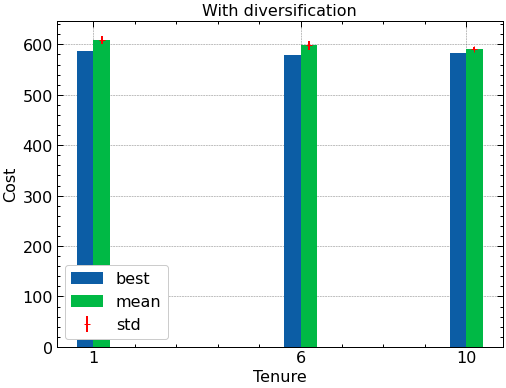

In [13]:
best = [np.min(scores) for scores in results_diver]
mean = [np.mean(scores) for scores in results_diver]
std = [np.std(scores) for scores in results_diver]

print("Results - With diversification:")
print("Best: ", best)
print("Mean: ", mean)
print("Std: ", std)

tenures = np.array(tenures)
plt.bar(tenures-0.2, best, 0.4, label="best")
plt.bar(tenures+0.2, mean, 0.4, label="mean")
plt.errorbar(tenures+0.2, mean, np.array(std)/2, fmt='+', c='r', label="std")

plt.title("With diversification")
plt.xticks(tenures)
plt.xlabel("Tenure")
plt.ylabel("Cost")
plt.legend()

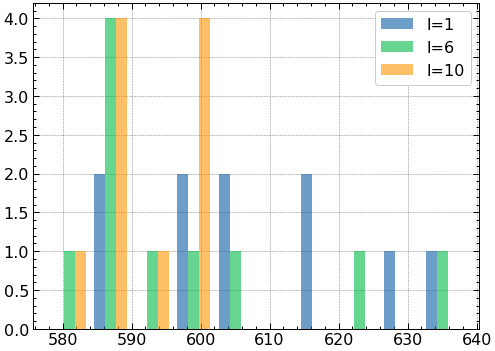

In [29]:
plt.hist(results_diver, bins=None, alpha=0.6, label=['l=1', 'l=6', 'l=10'])

plt.legend()

## Optional part - generate random distance and weight matrices for n = 10,20,30,40,50

We generate the matrix D according to a Poisson distribution with $\lambda=n/10$, and W according to a truncated normal distribution with variance 20.

In [99]:
N = [10, 20, 30, 40, 50]

D, W = [], []
for n in N:
    d = np.random.poisson(lam=n/10, size=(n,n))
    w = np.random.randint(20, size=(n,n))
    d = (d+d.T)//2
    w = (w+w.T)//2
    np.fill_diagonal(d, 0)
    np.fill_diagonal(w, 0)
    D.append(d)
    W.append(w)

In [100]:
# no diversification
qaps = [[] for _ in N]
times = [[] for _ in N]
max_t = 100

for i in tqdm(range(5)):
    # print("iteration - ", i)
    for k, n in tqdm(enumerate(N)):
        start = process_time()
        ts = QAPTabuSearch(n, D[k], W[k], diversification=True, tenure=n//2, max_t=max_t)
        _, score, _ = ts.search()
        
        t = process_time()-start
        print('it - ', i, ', t: ', t, 's')
        times[k].append(t)
        qaps[k].append(score)

  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

it -  0 , t:  0.4023636000001716 s
it -  0 , t:  4.501198800000566 s
it -  0 , t:  21.29994170000009 s
it -  0 , t:  69.77897109999958 s
it -  0 , t:  169.90585499999997 s


0it [00:00, ?it/s]

it -  1 , t:  0.29835370000000694 s
it -  1 , t:  4.297867600000245 s
it -  1 , t:  21.58662120000008 s
it -  1 , t:  65.29815289999988 s
it -  1 , t:  170.19935290000012 s


0it [00:00, ?it/s]

it -  2 , t:  0.3182702000003701 s
it -  2 , t:  4.873357599999508 s
it -  2 , t:  21.321867399999974 s
it -  2 , t:  67.54030030000013 s
it -  2 , t:  173.5628913999999 s


0it [00:00, ?it/s]

it -  3 , t:  0.3257495999996536 s
it -  3 , t:  4.073079400000097 s
it -  3 , t:  20.845274600000266 s
it -  3 , t:  70.00541150000026 s
it -  3 , t:  166.87949509999999 s


0it [00:00, ?it/s]

it -  4 , t:  0.3076021999995646 s
it -  4 , t:  4.074300799999946 s
it -  4 , t:  23.940702500000043 s
it -  4 , t:  68.2217213999993 s
it -  4 , t:  161.17344429999957 s


In [101]:
print(qaps)

[[412.0, 466.0, 476.0, 456.0, 468.0], [4858.0, 4938.0, 4890.0, 4910.0, 4888.0], [18934.0, 18684.0, 18936.0, 18828.0, 18804.0], [49976.0, 50206.0, 50282.0, 50140.0, 49866.0], [102932.0, 102712.0, 102598.0, 102548.0, 103196.0]]


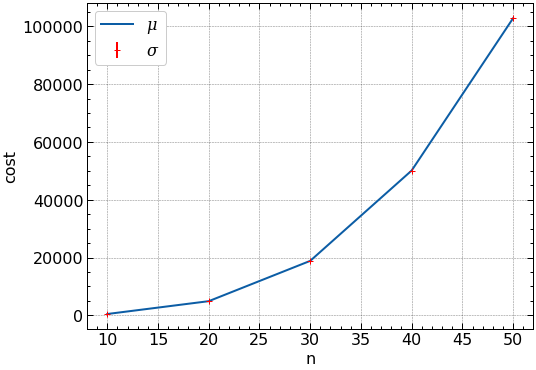

In [113]:
best = [np.min(scores) for scores in qaps]
mean = [np.mean(scores) for scores in qaps]
std = np.array([np.std(scores) for scores in qaps])


plt.plot(N, mean, label=r'$\mu$')
plt.errorbar(N, mean, std, fmt='+', c='r', label=r'$\sigma$')

plt.xlabel('n')
plt.ylabel('cost')
plt.legend()

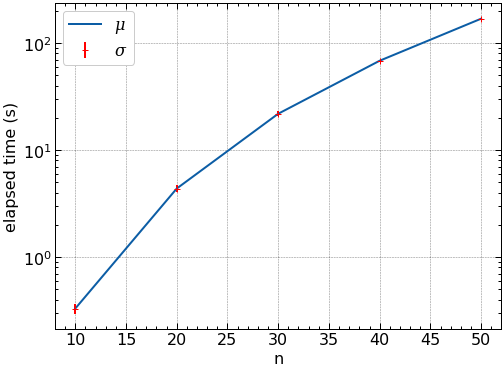

In [116]:
mean_times = [np.mean(t) for t in times]
std_times = [np.std(t) for t in times]


plt.plot(N, mean_times, label=r'$\mu$')
plt.errorbar(N, mean_times, std_times, fmt='+', c='r', label=r'$\sigma$')

plt.yscale('log')
plt.xlabel('n')
plt.ylabel('elapsed time (s)')
plt.legend()